57 вариант

E U N W K T M L R I

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
import scipy
from collections import Counter
import copy
%matplotlib inline

 ## №1

In [8]:
from BranchingProcess import Person, BranchingProcess, read_from_files
file_pref = ['E','U','N','W','K','T','M','L','R','I']
# file_all = 'C,D,E,F,G,I,J,K,L,M,N,O,P,Q,R,S,T,U,W'
# pref_all = file_all.split(',')
file_names = ['data/' + pref + '.txt' for pref in file_pref]

In [9]:
processes = read_from_files(file_names)

In [10]:
print(len(processes))

74142


In [11]:
# delete dummy nodes (with unknown gender and has no children(leaf in generation-tree))
def clear_data(processes) :
    processes_new = []
    for proc in processes :
        new_proc = BranchingProcess()
        children = set()
        proc.generations.reverse()

        for generation in proc.generations:
            new_generation = []
            for person in generation :
                
                if person.gender == 'male' or person.gender == 'female':
                    children.add(person.name)
                    new_generation.append(person)    
#                 else :     
#                     is_leaf = True
#                     for ch in person.children:
#                         if ch in children :
#                             is_leaf = False
#                             break
#                     if not is_leaf :
#                         new_generation.append(person)    

            if len(new_generation) > 0 :
                new_generation.reverse()
                new_proc.generations.append(new_generation)

        if len(new_proc.generations) > 1 :
            processes_new.append(new_proc)
    return processes_new


In [12]:
processes = clear_data(processes)

In [13]:
print(len(processes))

21242


In [14]:
# check that all deleted items were leafs
for proc in processes :
    for generation in proc.generations:
        for person in generation :
            if person.gender != 'male' and person.gender != 'female':
                print("Empty NO-leaf")

## №2

In [15]:
lenghts = [len(proc.generations) for proc in processes]
min_family_length = np.min(lenghts)
max_family_length = np.max(lenghts)
avg_family_length = np.mean(lenghts)
print('min family length = ' + str(min_family_length))
print('max family length = ' + str(max_family_length))
print('avg family length = ' + str(round(avg_family_length,2)))

min family length = 2
max family length = 81
avg family length = 3.25


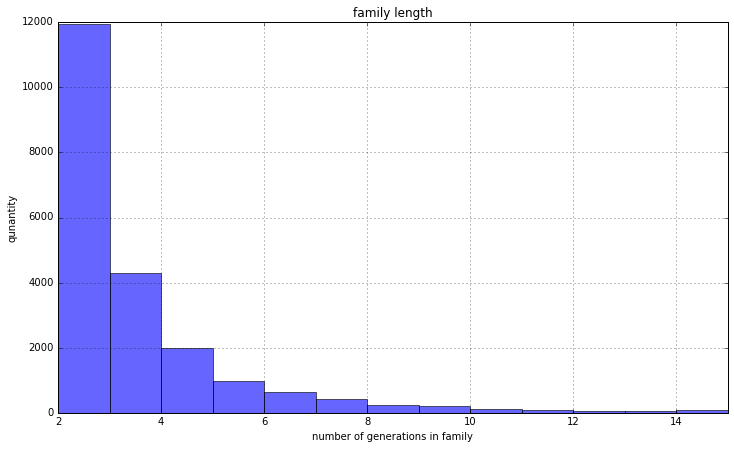

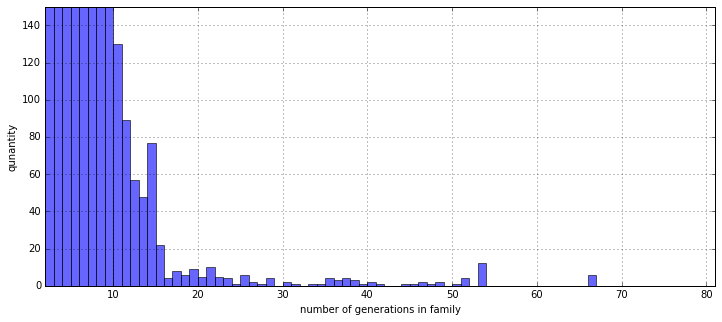

In [16]:
plt.figure(figsize=(12,7))
plt.title("family length")

plt.hist(lenghts, bins=np.arange(80), facecolor='b', alpha=0.6)
plt.grid(True)
plt.xlim(2,15)
plt.xlabel("number of generations in family")
plt.ylabel("qunantity")
plt.show()


plt.figure(figsize=(12,5))
plt.grid(True)
plt.ylim(0,150)
plt.xlim(2,81)
plt.xlabel("number of generations in family")
plt.ylabel("qunantity")
plt.hist(lenghts,  bins=np.arange(80), facecolor='b', alpha=0.6)
plt.show()


In [17]:
# this function returns year(int) from date-info string
def get_year(s) : 
    if len(s) == 0:
        return -5000
    x = s.split('-')
    if(x[0] == '') :
        return -5000
    return int(x[0])


birth_years = []
life_time = []
# max_first_gen = 0
for proc in processes :
#     max_first_gen = max(max_first_gen,len(proc.generations[0]))
    for generation in proc.generations :
        for p in generation : 
            byear = get_year(p.birthday)
            dyear = get_year(p.deathdate)
            if byear > -5000:
                birth_years.append(byear)
                if dyear > -5000 :
                    life_time.append(dyear - byear)
            
min_birthyear , max_birthyear = np.min(birth_years) , np.max(birth_years)
avg_life_time = np.mean(life_time)
# print(max_first_gen)
print('min value of birthyear = ' + str(min_birthyear))
print('max value of birthyear = ' + str(max_birthyear))
print('avg value of life time = ' + str(round(avg_life_time,1)))

min value of birthyear = 1
max value of birthyear = 2007
avg value of life time = 57.7


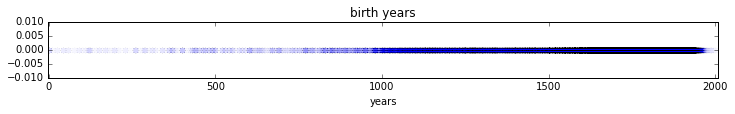

In [18]:
plt.figure(figsize=(12,1))
plt.ylim(-0.01,0.01)
plt.xlim(-1,2008)
plt.xlabel("years")
plt.title("birth years")
plt.plot([x for x in birth_years],[0 for i in range(len(birth_years))],'o',alpha = 0.002)
plt.show()

## №3

In [19]:
def pois_likelyhood_estimation(X) :
    return np.mean(X)    

В данных сложные фамилии могут быть представлены двумя способами, с пробелом или нижним подчеркиванием.

Поэтому нормализуем все имена в процессе обработки.

Также не будем рассматривать как бездетных мужчин, у которых не указана дата смерти, но которых уже "почти наверное" нет в живых ( > 96 лет), так как о них, вероятнее всего, просто утеряна информация. ((*) - критерий)

In [46]:

def normalize_name(s) :
    return s.replace(' ' , '_')


#  add only non-leaf(not last generation in family) and older than 1950 birth year
#  delete if p has no death-year(but he must be already died)
def death_crit(person):
    return False #get_year(person.deathdate) <= -5000 and get_year(person.birthday) <= 1920
def is_bad_example(person) :
    return get_year(person.birthday) <= -5000 or get_year(person.birthday) >= 1950 \
        or death_crit(person)
            

X = []
# print(processes[1].generations[0][0])
t = 0
for proc in processes :
    offspring = dict()
    # calc number of sons for each father
    for generation in proc.generations:
        for person in generation :
            person.name = normalize_name(person.name)
            if person.gender == 'male' and len(person.parents) > 0 and len(person.parents[0]) > 0 :
                person.parents[0] = normalize_name(person.parents[0])
                if person.parents[0] not in offspring :
                    offspring[person.parents[0]] = 0 
                offspring[person.parents[0]] += 1
    
    #assign by zero for no-sons fathers       
    i = 0
    for generation in proc.generations:
        i += 1
        for person in generation :
            person.name = normalize_name(person.name)
            if person.gender == 'male' and person.name not in offspring :
                if i < len(proc.generations) and not is_bad_example(person):
                    offspring[person.name] = 0
    vals = list(offspring.values())
    if len(vals) > 0 :
        X.append(vals)
        
X_all = []
for x in X :
    X_all += x

Рассмотрим 2 дискретных распределения: геометрическое и распределение Пуассона.

Оценка максимального правдоподобия:
 - для Пуассоновского распределения : $ \hat \lambda = \overline X$
 - для геометрического : $ \hat p = \frac{1}{\overline X + 1}$


In [47]:
pois_lmb_all = pois_likelyhood_estimation(X_all)
pois_lmb = np.array([pois_likelyhood_estimation(x) for x in X])
p_geom = 1/(pois_lmb + 1)
p_geom_all = 1/(pois_lmb_all + 1)
print('lambda_all = ' + str(pois_lmb_all)) 
print('p_geom_all = ' + str(p_geom_all))

lambda_all = 1.00264484776
p_geom_all = 0.499339661308


In [26]:
freq_all = list(Counter(X_all).values())
freq = []
for x in X:
    freq.append(list(Counter(x).values()))

#build general discrete distribution
def discrete_ppf(x , i) :
    if x >= len(frec[i]) :
        return 0
    return frec[i][x]/np.sum(frec[i])
def discrete_ppf_all(x) :
    if x >= len(frec_all) :
        return 0
    return frec_all[x]/np.sum(frec_all)

[50106, 37574, 11986, 7248, 5189, 3380, 2194, 1240, 553, 348, 160, 81, 28, 28, 10, 3, 4, 2, 3, 2]
120139


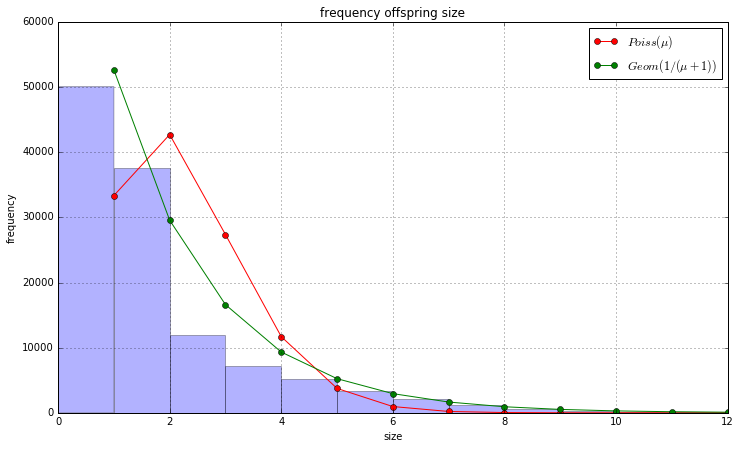

In [27]:
print(freq_all)
print(np.sum(freq_all))
n = np.sum(freq_all)
plt.figure(figsize=(12,7))
plt.title("frequency offspring size")
plt.hist(X_all, bins=np.arange(20) , facecolor='b', alpha=0.3)
plt.plot(np.arange(1,21) , [n*sps.poisson.pmf(x,mu=pois_lmb_all) for x in range(20)] ,
         '-o' ,color='r', label = r'$Poiss(\mu)$')
plt.plot(np.arange(1,21) , [n*sps.geom.pmf(x+1,1/(pois_lmb_all+1)) for x in range(20)] ,
         '-o' ,color='g',  label = r'$Geom(1/(\mu+1))$')
plt.legend()
plt.grid(True)
plt.xlim(0,12)
plt.xlabel("size")
plt.ylabel("frequency")
plt.show()

Критерий $\chi^2$ :

In [28]:
def get_chisquare_check(prob, f_obs, mu) :
    n = np.sum(f_obs)
    fexp = [n*prob(i,mu) for i in range(len(f_obs))]
    val , p = sps.chisquare(f_obs, f_exp=fexp)
    return val,p

In [30]:
poiss_f = lambda x,mu : sps.poisson.pmf(x,mu)
geom_f = lambda x,p : sps.geom.pmf(x+1,p)
print('pois : ' + str(get_chisquare_check(poiss_f,freq_all,pois_lmb_all+3.1)))
print('geom : ' + str(get_chisquare_check(geom_f,freq_all,p_geom_all)))

pois : (1779726.5200562908, 0.0)
geom : (4420.4038046725873, 0.0)


Критерий ХИ квадрат показал, что нет почти никаких оснований не отвергать гипотезы о том что закон распределения
принимает какое-то из этих распределений.

Но все же геометрическое распределение дает более точное приближение, в дальнейшем будем использовать его.

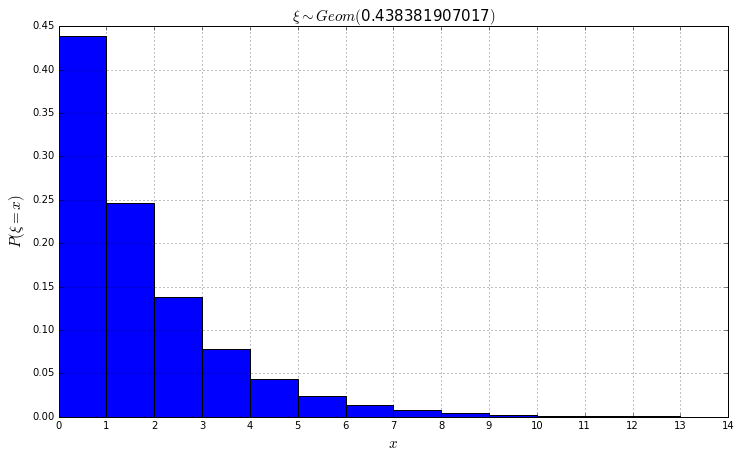

In [33]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.title(r'$\xi \sim Geom($' + str(p_geom_all) + r'$)$',size=15)
plt.xlim(0,14)
plt.xlabel(r'$x$',size=15)
plt.ylabel(r'$P(\xi = x)$',size=15)
width = 1
OX = np.arange(15)
plt.bar(OX,[geom_f(x,p_geom_all) for x in OX], width)
plt.xticks(OX)
plt.show()

## №4

 ## №5

Найдем среднее время до появления следующего поколения

In [34]:
gen_dists = []
for proc in processes:
    avg_byears = []
    for gen in proc.generations:
        bdays =[]
        for p in gen:
            if(p.gender != 'male'):
                continue
            bdy = get_year(p.birthday)
            if(bdy > -5000) :
                bdays.append(bdy)
        if(len(bdays) > 0):
            avg_byears.append(np.mean(bdays))
    for i in range(1,len(avg_byears)):
        if(avg_byears[i-1] - avg_byears[i] > 0) :
            gen_dists.append(avg_byears[i-1] - avg_byears[i])
# print(gen_dists)
avg_gen_distance = int(np.mean(gen_dists))
print('average year distance between generations = ' + str(avg_gen_distance))

average year distance between generations = 33


Для моделирования процесса "вперед" будем считать, что процессы не склеиваются, т.е. каждый процесс можно продолжить независимо от других. Разделим всех мужчин на активных и не активных, активные - находящиеся в последнем поколении процесса, а также, удовлетворяющие (*) - критерию(см. пункт 3). Тогда каждый активный мужчина с датой рождения $b\_year_i$ будет порождать $\xi_i \sim distr$ активных мужчин c датами рождения $b\_year_j = b\_year_i + avg\_dist$ , где $avg\_dist$ - среднее расстояние между двумя поколения. Будем считать за одно $n$-ое поколение  мужчин с датой рождения $b\_year \in [avg\_dist \cdot n,avg\_dist \cdot (n+1) - 1]$

In [52]:
first = 0
last = 80000
step = avg_gen_distance
def calc_forward_all(distr, param):
    active = np.zeros((last+1)//step + 1)
    population = np.zeros((last+1)//step + 1)
    
    for proc in processes:
        for i in range(len(proc.generations)) :
            gen = proc.generations[i]
            for p in gen:
                if p.gender != 'male':
                    continue
                bday = get_year(p.birthday)
                if bday > -5000 :
                    population[bday//step] += 1
                    if i == len(proc.generations) - 1 :
#                     or (len(p.children) == 0 and death_crit(p)):
                        active[bday//step] += 1
    base_population = copy.copy(population)
    for i in range(len(active) - 1):
        offspring = np.sum(distr(param,active[i]))
        active[i+1] += offspring
        population[i+1] += offspring

    plt.figure(figsize=(15,7))
    plt.grid(True)
    plt.xlabel('years')
    plt.ylabel('population')
    plt.plot(step*np.arange((last+1)//step + 1), base_population,color='b',label='base population')
    plt.plot(step*np.arange((last+1)//step + 1), population, color='r',label='reconstructed population')
    plt.plot(step*np.arange((last+1)//step + 1), active,'--' ,color='g', label='active population')
    plt.legend(loc = 'best',fontsize=12)
    plt.show()

In [ ]:
distr = [lambda lmb,sz : sps.poisson.rvs(lmb, size=sz),
         lambda p,sz : sps.geom.rvs(p,size=sz) , discrete_ppf_all]
names = ['poiss', 'geom' , 'discrete']
print('poiss(' + str(pois_lmb_all) + ')')
calc_forward_all(distr[0], pois_lmb_all)
# calc_forward_all(distr[1], p_geom)